# ASCT+B CT-Label Mapper

## Package has been deployed on the `PyPi` test server [here](https://test.pypi.org/project/asctb-ct-label-mapper/).

Ideally you should be able to install it on your local machine, but remember to install the `pytorch` dependent packages seperately.

In [ ]:
!pip uninstall asctb-ct-label-mapper

!pip install --index-url https://test.pypi.org/simple/ --no-deps asctb-ct-label-mapper

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


# Install external dependencies

Packages dependent on `pytorch` are tricky to handle in the pure Python package-build.

Hence, for now ensure that you've got `pytorch` setup on your local machine (Google Colab already has it set up).

Run the following `pip install` command to install the packages dependent transitively on `pytorch`.

In [ ]:
!pip install sentence-transformers contractions num2words umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

## Setting up the experimental pipeline

1. Create your raw-input labels as Python iterables (`np.array`/`list`/`set`/...)
2. Generate/Fetch the latest ASCT+B Embeddings for the specific Organ and Version (for more information on ASCT+B please visit the [ASCT+B Master Tables](https://hubmapconsortium.github.io/ccf-asct-reporter/)).
3. Map all input raw-labels to this standard controlled vocabulary maintained by ASCT+B.

Your final output should be a detailed Pandas dataframe containing information on cleaned-input-label, matched ASCTB label, cosine-similarity score, etc.

Choose a BERT model to create the reference embeddings.

We recommend the `mpnet-base-v2` model that was trained on 1 billion training sentence-pairs. It performs very well as a sentence and paragraph encoder. Given an input text, it outputs a vector which captures semantic information to be used for information retrieval, clustering, or text similarity tasks.

>  MPNet : `Masked and Permuted Pre-training for Language Modeling`

Other models hosted on HuggingFace are available: [here](https://www.sbert.net/docs/pretrained_models.html).

In [ ]:
from sentence_transformers import SentenceTransformer

SENTENCE_ENCODING_MODEL = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
import numpy as np, pandas as pd, nltk


VERBOSE = False
ASCTB_ORGAN = 'Lung'
ASCTB_VERSION = 'v1.2'
MAX_TEXT_LENGTH = 200 # len(text) to use while converting into embedding
K = 2


celltypist_labels = np.array([
    'EC aerocyte capillary', 'EC general capillary', 'Mesothelium', 'EC venous pulmonary', 'EC arterial', 
    'Lymphatic EC mature', 'EC venous systemic', 'Smooth muscle', 'AT1', 'Mast cells', 'Interstitial MÏ† perivascular', 
    'Monocyte-derived MÏ†', 'Alveolar MÏ† CCL3+', 'Alveolar macrophages', 'DC2', 'Classical monocytes', 'DC1', 
    'Plasmacytoid DCs', 'NK cells', 'B cells', 'Plasma cells', 'Non-classical monocytes', 'Alveolar MÏ† proliferating', 
    'AT2', 'Transitional Club-AT2', 'Pericytes', 'Adventitial fibroblasts', 'CD8 T cells', 'CD4 T cells', 'Club (non-nasal)', 
    'Suprabasal', 'AT2 proliferating', 'Basal resting', 'T cells proliferating', 'Multiciliated (non-nasal)', 
    'Alveolar fibroblasts', 'Myofibroblasts', 'Neuroendocrine', 'Ionocyte'
])

azimuth_labels = np.array([
    'EC aerocyte capillary', 'EC general capillary', 'EC venous pulmonary', 'EC arterial', 'Club (non-nasal)', 
    'Smooth muscle', 'Suprabasal', 'AT1', 'Mast cells', 'Interstitial Mφ perivascular', 'DC2', 'Monocyte-derived Mφ', 
    'DC1', 'Migratory DCs', 'Plasmacytoid DCs', 'B cells', 'Plasma cells', 'Classical monocytes', 'Non-classical monocytes', 
    'Basal resting', 'Alveolar Mφ CCL3+', 'Alveolar macrophages', 'Transitional Club-AT2', 'CD4 T cells', 'Pericytes', 
    'Mesothelium', 'NK cells', 'CD8 T cells', 'EC venous systemic', 'AT2', 'Adventitial fibroblasts', 'Alveolar fibroblasts',
    'AT2 proliferating', 'Lymphatic EC mature', 'Alveolar Mφ proliferating', 'T cells proliferating', 'Myofibroblasts', 
    'Multiciliated (non-nasal)', 'Multiciliated (nasal)', 'Peribronchial fibroblasts', 'Neuroendocrine', 
    'Subpleural fibroblasts', 'Ionocyte', 'Club (nasal)', 'Fibromyocytes', 'SMG duct', 'SMG serous (bronchial)', 
    'Deuterosomal', 'Goblet (nasal)', 'Goblet (bronchial)', 'SMG mucous', 'Tuft'
])



popv_labels = np.array([
    'non-classical monocyte', 'classical monocyte', 'CD8-positive, alpha-beta T cell', 'mature NK T cell', 'CD4-positive, alpha-beta T cell', 
    'basophil', 'capillary endothelial cell', 'endothelial cell of artery', 'lung microvascular endothelial cell', 'vein endothelial cell', 
    'dendritic cell', 'blood vessel endothelial cell', 'endothelial cell of lymphatic vessel', 'type II pneumocyte', 'fibroblast', 
    'bronchial smooth muscle cell', 'macrophage', 'intermediate monocyte', 'B cell', 'type I pneumocyte', 'club cell', 'respiratory goblet cell', 
    'basal cell', 'effector CD4-positive, alpha-beta T cell', 'adventitial cell', 'lung ciliated cell', 'mesothelial cell', 'pericyte', 
    'vascular associated smooth muscle cell', 'plasma cell', 'smooth muscle cell', 'plasmacytoid dendritic cell', 'neutrophil', 
    'pulmonary ionocyte', 'serous cell of epithelium of bronchus'
    ])


source_vs_labels_dict = {
    'CellTypist' : celltypist_labels,
    'Azimuth' : azimuth_labels, 
    'PopV' : popv_labels
}

In [ ]:
from asctb_ct_label_mapper.utilities.nlp_preprocessing import download_nlp_models

# Download the NLP preprocessing artifacts
download_nlp_models()

Models downloaded and ready for use!


In [ ]:
from asctb_ct_label_mapper.main import fetch_asctb_reference_embeddings, map_raw_labels_to_asctb


MAX_TEXT_LENGTH = 300

# Generate the ASCT+B reference embeddings
asctb_embeddings_df = fetch_asctb_reference_embeddings(
    sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
    asctb_organ=ASCTB_ORGAN, 
    asctb_version=ASCTB_VERSION, 
    max_text_length=MAX_TEXT_LENGTH,
    verbose=VERBOSE
)

# Maintain a report dataframe so we can view agreeability across scRNA-seq datasets/algorithms.
ctlabels_translations_df = pd.DataFrame()

for SOURCE, RAW_LABELS in source_vs_labels_dict.items():
  print(f'Standardizing labels for {SOURCE}')
  # Map each of the iterable raw-input labels to an ASCT+B label.
  raw_to_asctb_labels_df = map_raw_labels_to_asctb(
      source_name=SOURCE,
      raw_labels=RAW_LABELS,
      sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
      asctb_embeddings_df=asctb_embeddings_df,
      k=K,
      verbose=VERBOSE
  )
  # Append to the report dataframe
  ctlabels_translations_df = pd.concat([
      ctlabels_translations_df,
      raw_to_asctb_labels_df
  ])



TGT_FILENAME = 'data/All_CTlabels_translations.csv'

try:
    ctlabels_translations_df.loc[ctlabels_translations_df['matched_asctb_label_1'].isna(), 'matched_asctb_label_1'] = ctlabels_translations_df.loc[ctlabels_translations_df['matched_asctb_label_1'].isna(), 'cleaned_input_label']
    ctlabels_translations_df.to_csv(TGT_FILENAME, index=False)
    print('Wrote the final translations-mapping files to csv!')
except Exception as e:
    print(f'Something went wrong while trying to write the csv: {e}')

ctlabels_translations_df

Created the reference embeddings for Lungv1.2 at ontology_embeddings/ASCTB_Lungv1_2.pkl.
asctb_embeddings_df=(83, 6)
Standardizing labels for CellTypist
Standardizing labels for Azimuth
Standardizing labels for PopV
Wrote the final translations-mapping files to csv!


,source,raw_input_label,cleaned_input_label,match_score_1,matched_asctb_id_1,matched_asctb_label_1,matched_asctb_text_1,match_score_2,matched_asctb_id_2,matched_asctb_label_2,matched_asctb_text_2
0,CellTypist,EC aerocyte capillary,ec aerocyte capillary,0.601205,CL:4028003,CAP2 aerocyte capillary gCap,CAP2 aerocyte capillary gCap capillary endothe...,0.503849,CL:0002062,AT1,AT1 type I pneumocyte A type I pneumocyte is a...
1,CellTypist,EC general capillary,ec general capillary,0.477796,CL:4028002,CAP1 general capillary aCap,CAP1 general capillary aCap capillary endothel...,0.428388,CL:4028003,CAP2 aerocyte capillary gCap,CAP2 aerocyte capillary gCap capillary endothe...
2,CellTypist,Mesothelium,mesothelium,0.52519,CL:1000493,mesothelial cell,mesothelial cell mesothelial cell of visceral ...,0.393562,ASCTB CT_ID UNK,suprabasal cell,suprabasal cell
3,CellTypist,EC venous pulmonary,ec venou pulmonary,0.632037,CL:0002543,pulmonary venous endothelial cell,pulmonary venous endothelial cell vein endothe...,0.503114,CL:0002543,venous endothelial cell,venous endothelial cell vein endothelial cell ...
4,CellTypist,EC arterial,ec arterial,0.51338,CL:1000413,arterial endothelial cell,arterial endothelial cell arterial endothelial...,0.460811,CL:0002543,venous endothelial cell,venous endothelial cell vein endothelial cell ...
...,...,...,...,...,...,...,...,...,...,...,...
30,PopV,smooth muscle cell,smooth muscle cell,0.770995,CL:0002598,bronchial smooth muscle cell,bronchial smooth muscle cell bronchial smooth ...,0.732254,CL:0002591,pulmonary artery smooth muscle cell,pulmonary artery smooth muscle cell smooth mus...
31,PopV,plasmacytoid dendritic cell,plasmacytoid dendritic cell,1.0,CL:0000784,plasmacytoid dendritic cell,"A dendritic cell type of distinct morphology, ...",NaN,NaN,NaN,NaN
32,PopV,neutrophil,neutrophil,1.0,CL:0000094,neutrophil,A leukocyte with abundant granules in the cyto...,NaN,NaN,NaN,NaN
33,PopV,pulmonary ionocyte,pulmonary ionocyte,1.0,CL:0017000,pulmonary ionocyte,An ionocyte that is part of the lung epitheliu...,NaN,NaN,NaN,NaN


# Simpler use case for 1 set of input-labels to be mapped to ASCT+B

Creating Crosswalks from one data-source to ASCT+B is possible too!

**Note**:
* These output reports are meant to be a starting point for creating a standard Crosswalk from Source-A to ASCT+B.
* They should still be reviewed by an SME (Biomedical/BioInformatics domains).

In [ ]:
from asctb_ct_label_mapper.main import fetch_asctb_reference_embeddings, map_raw_labels_to_asctb


VERBOSE = False
ASCTB_ORGAN = 'Lung'
ASCTB_VERSION = 'v1.2'
K = 2

RAW_LABELS = ['AT1','AT2']
SOURCE_NAME = 'Azimuth-HLCAv2'
SENTENCE_ENCODING_MODEL = SentenceTransformer('all-mpnet-base-v2')




# Generate the ASCT+B reference embeddings
asctb_embeddings_df = fetch_asctb_reference_embeddings(
    sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
    asctb_organ=ASCTB_ORGAN, 
    asctb_version=ASCTB_VERSION, 
    verbose=VERBOSE
)

# Map each input label to closest-K-neighbors in ASCT+B
report_df = map_raw_labels_to_asctb(
    source_name=SOURCE_NAME,
    raw_labels=RAW_LABELS,
    sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
    asctb_embeddings_df=asctb_embeddings_df,
    k=K,
    verbose=VERBOSE
)

report_df

Found pre-computed embeddings at ontology_embeddings/ASCTB_Lungv1_2.pkl. Using these again!


,source,raw_input_label,cleaned_input_label,match_score_1,matched_asctb_id_1,matched_asctb_label_1,matched_asctb_text_1,match_score_2,matched_asctb_id_2,matched_asctb_label_2,matched_asctb_text_2
0,Azimuth-HLCAv2,AT1,at1,1.0,CL:0002062,AT1,"A type I pneumocyte is a flattened, branched p...",NaN,NaN,NaN,NaN
1,Azimuth-HLCAv2,AT2,at2,1.0,CL:0002063,AT2,A type II pneumocyte is a pneumocyte that modu...,NaN,NaN,NaN,NaN


# Visualize the agreeability of cross-dataset annotations before and after using [ASCTB CT Label Mapper](https://github.com/hubmapconsortium/asctb-ct-label-mapper).

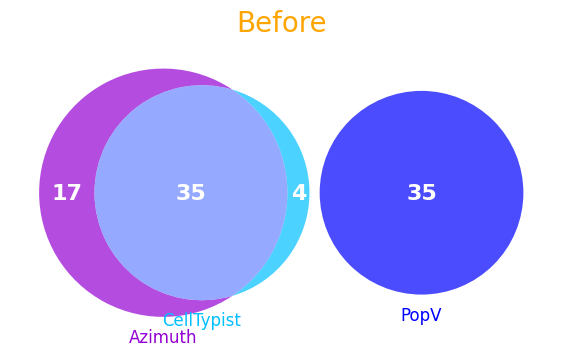

In [ ]:
from asctb_ct_label_mapper.utilities.plotting import make_venn_diagram



all_combos = ctlabels_translations_df.groupby(by=['source'])['raw_input_label'].apply(set)
all_sets_list = all_combos.values.tolist()
all_labels = all_combos.index.tolist()
_ = make_venn_diagram(
    A=all_sets_list[0],
    B=all_sets_list[1],
    C=all_sets_list[2],
    labels=(all_labels),
    title='Before'
    )

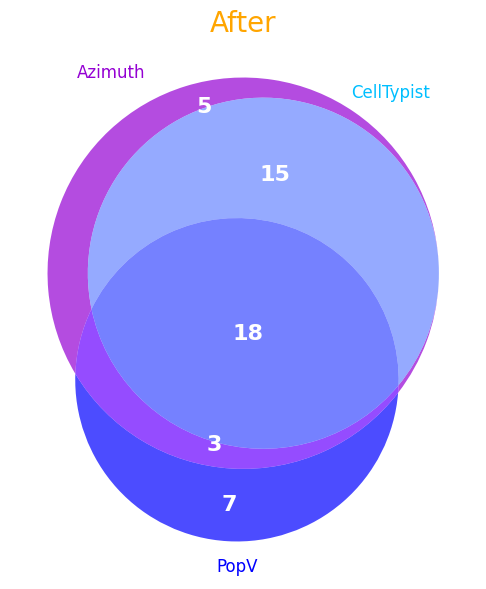

In [ ]:
from asctb_ct_label_mapper.utilities.plotting import make_venn_diagram



all_combos = ctlabels_translations_df.groupby(by=['source'])['matched_asctb_label_1'].apply(set)
all_sets_list = all_combos.values.tolist()
all_labels = all_combos.index.tolist()
_ = make_venn_diagram(
    A=all_sets_list[0],
    B=all_sets_list[1],
    C=all_sets_list[2],
    labels=(all_labels),
    title='After'
    )

## Let's try to visualize the UMAP of the ASCT+B annotation-embeddings

In [ ]:
import plotly.express as px
from umap import UMAP


embeddings_df = pd.read_pickle('ontology_embeddings/ASCTB_Lungv1_2.pkl')
embeddings_df.loc[embeddings_df['CT_LABEL'].isna(), 'CT_LABEL'] = embeddings_df.loc[embeddings_df['CT_LABEL'].isna(), 'CT_NAME'].fillna('Unknown CT-Label')
embeddings_df.loc[embeddings_df['definition'] == 'NaN', 'definition'] = embeddings_df.loc[embeddings_df['definition'] == 'NaN', 'CT_LABEL']
embedding_matrix = embeddings_df['embedding_results'].to_numpy()

umap_embedding = UMAP(random_state=0, n_components=2)

features = np.vstack(embedding_matrix)
projections = umap_embedding.fit_transform(features)
projections_df = pd.DataFrame(projections)

N_CHARS_DEFINITION_HOVER = 150
projections_df['Definition'] = [ definition[:N_CHARS_DEFINITION_HOVER] for definition in embeddings_df.loc[:, 'definition'].values ]
projections_df['CT_ID'] = embeddings_df.loc[:, 'CT_ID'].replace('ASCTB CT_ID UNK', 'Unknown CT-ID').values
projections_df['CT_LABEL'] = embeddings_df.loc[:, 'CT_LABEL']
projections_df['CT_NAME'] = embeddings_df.loc[:, 'CT_NAME']


fig = px.scatter(
    projections_df, 
    height=1000,
    width=1500,
    x=0, 
    y=1,
    # z=2,
    color='CT_LABEL',
    hover_name='CT_ID',
    hover_data=['CT_NAME', 'Definition'],
    title=f'UMAP projection for sentence-embeddings of ASCT+B {ASCTB_ORGAN}-{ASCTB_VERSION} Cell-Type annotations'
)

fig.show()